# Titanic Survival Prediction 
> <b>Dataset used</b> : https://www.kaggle.com/c/titanic/data <br> <br>
> <b>Steps followed </b> : <ol>
    <li>Import data</li>
    <li>Perform EDA</li>
    <li>Prep the data for modelling</li>
    <li>Apply Models & Evaluate</li>
    <li>Hyperparamter Tuning</li>
</ol> 
<b>Description:</b> Predicts if a passenger would have survived on the titanic

In [85]:
#Data Analysis & Wrangling
import numpy as np
import pandas as pd
from collections import Counter

#Visualization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#Model Evaluation
from sklearn.model_selection import cross_val_score

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#remove warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import Datasets

In [2]:
train = pd.read_csv('../Dataset/train.csv')
test = pd.read_csv('../Dataset/test.csv')
sample = pd.read_csv('../Dataset/gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
sample.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 2. Perform EDA

In [6]:
print('Training set : ', train.shape)
print('Test set : ', test.shape)
print('Sample Submission set : ', sample.shape)

Training set :  (891, 12)
Test set :  (418, 11)
Sample Submission set :  (418, 2)


In [7]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [8]:
train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [9]:
test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

Age, Cabin and Embarked have null values.
Cabin has >60% null values (we can drop this column)
We need to impute Age and Embarked (Since Age is numerical, imputed using mean/median, Embarked - using mode)

<AxesSubplot:>

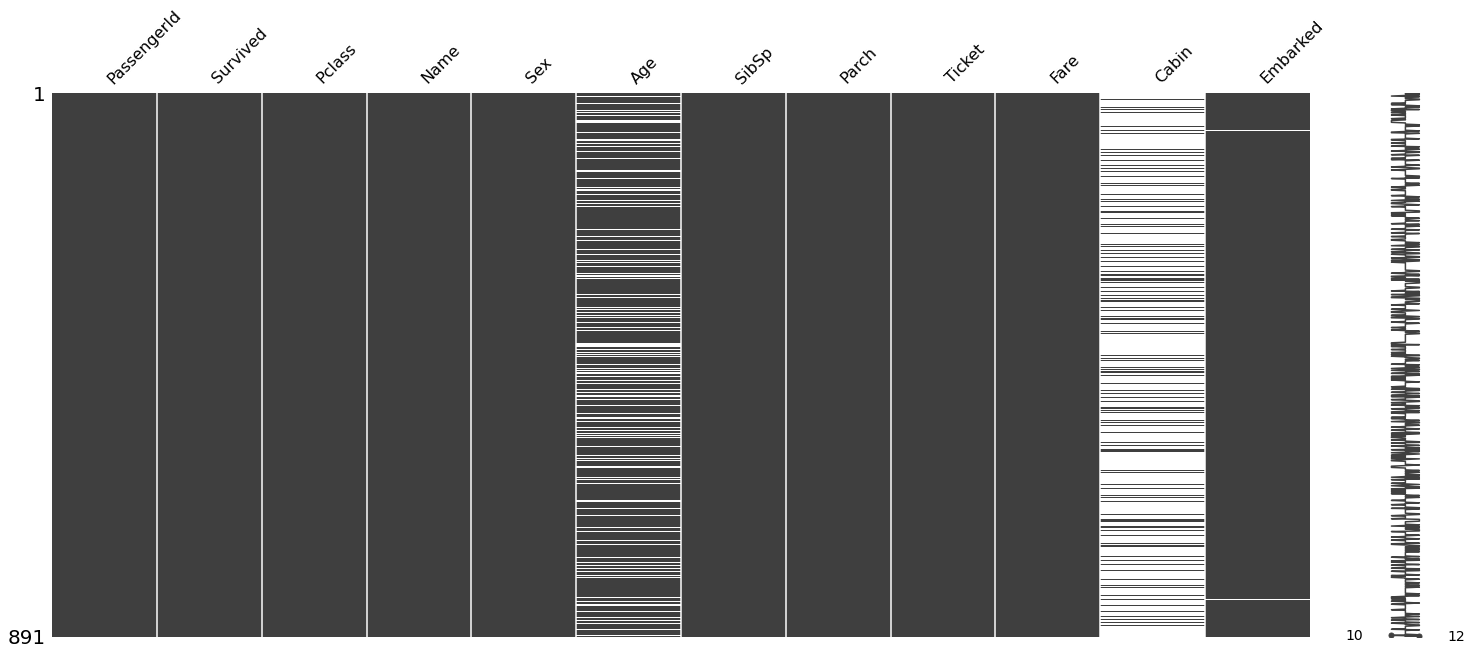

In [10]:
missingno.matrix(train)

<AxesSubplot:>

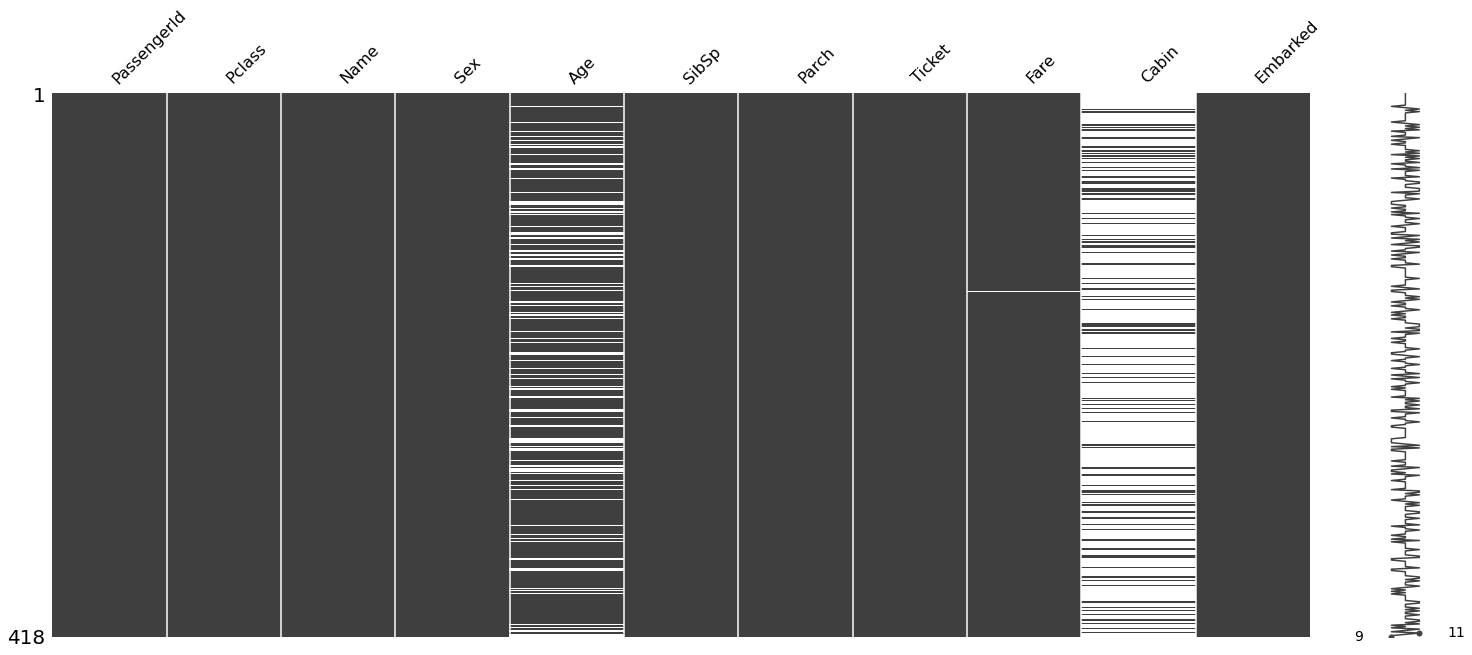

In [11]:
missingno.matrix(test)

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Feature Analysis
> Categorical Values in our dataset <ul>
    <li>Sex</li>
    <li>Pclass</li>
    <li>Embarked</li>
    </ul>

In [14]:
train['Sex'].value_counts(dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [15]:
train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

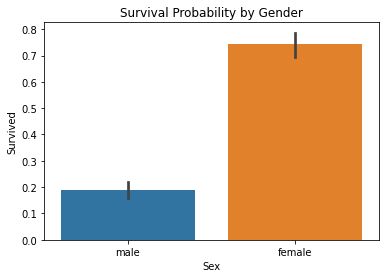

In [16]:
sns.barplot(x='Sex', y='Survived', data = train)
plt.ylabel('Survived')
plt.title('Survival Probability by Gender')

In [17]:
train['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [18]:
train[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

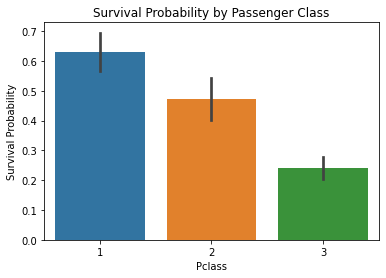

In [19]:
sns.barplot(x='Pclass', y='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

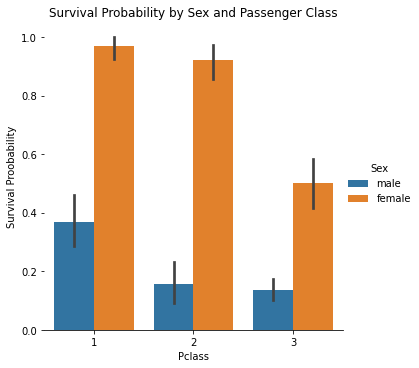

In [20]:
g = sns.catplot(x = 'Pclass', y='Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left=True)
plt.ylabel('Survival Proobability')
plt.title('Survival Probability by Sex and Passenger Class')

In [21]:
train["Embarked"].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [22]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by='Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by point of Embarkation')

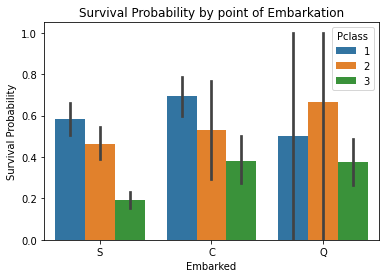

In [23]:
sns.barplot(x = 'Embarked', y = 'Survived', hue = 'Pclass', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by point of Embarkation')

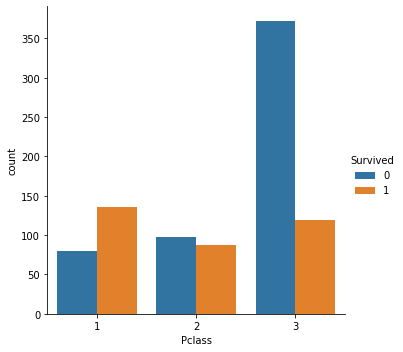

In [24]:
sns.catplot(x = 'Pclass', hue = 'Survived', kind = 'count', data = train)

### Detecting and removing outliers since they can skew our data to the extremes

In [25]:
def detect_outliers(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5*IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n )
    return multiple_outliers
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("Indices to drop are : {}".format(len(outliers_to_drop)), outliers_to_drop)

Indices to drop are : 10 [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [26]:
train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [27]:
#Drop the outliers and reset the index

print('No. of rows before drop : {}'.format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("No. of rows after drop : {}".format(len(train)))

No. of rows before drop : 891
No. of rows after drop : 881


### Numerical Variables Correlation with survival

<AxesSubplot:>

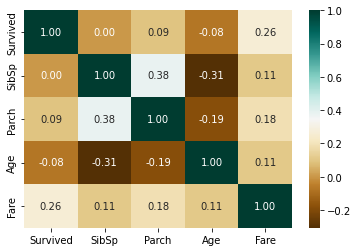

In [28]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'BrBG')

We can see that among the numerical values, "Fare" is the only feature that has a considerable correlation with survival - "0.26"

## Feature Analysis 
> <b>Numerical Features : </b> <ul>
    <li>SibSp</li>
    <li>Parch</li>
    <li>Age</li>
    </ul>

In [29]:
train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [30]:
train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by='Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0, 0.5, 'Survival Probability')

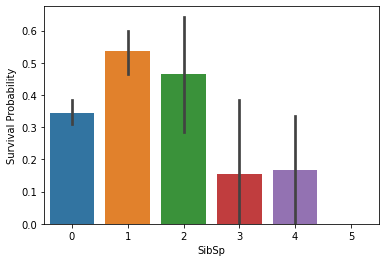

In [31]:
sns.barplot(x='SibSp', y='Survived', data=train)
plt.ylabel('Survival Probability')

In [32]:
train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [33]:
train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by='Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0, 0.5, 'Survival Probability')

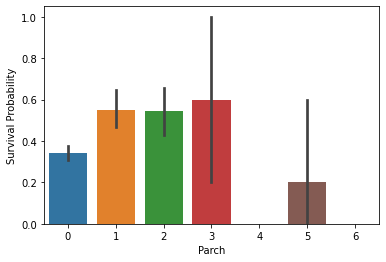

In [34]:
sns.barplot(x='Parch', y='Survived', data=train)
plt.ylabel('Survival Probability')

In [35]:
train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

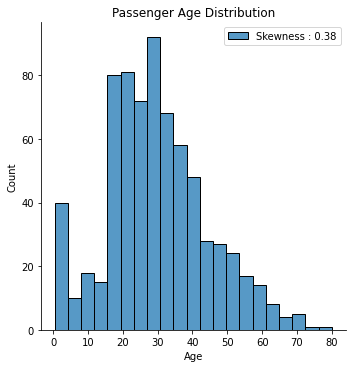

In [36]:
sns.displot(train['Age'], label = 'Skewness : %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

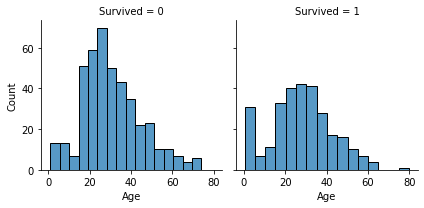

In [37]:
#  Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.histplot, 'Age')

In [38]:
train['Fare'].isnull().sum()

0

Text(3.674999999999997, 0.5, 'Passenger Fare Distribution')

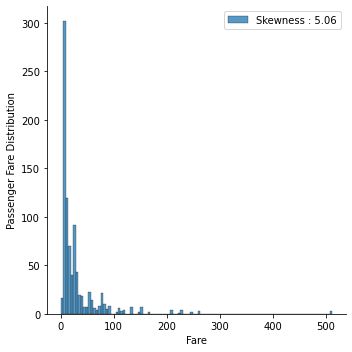

In [39]:
sns.displot(train['Fare'], label='Skewness : %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

<b>Data is highly skewed.</b>

### Summary of EDA : 
<ol> 
    <li>Female passengers were more likely to survive than male passengers.</li>
    <li>1st Class passenger have a better probability of survival.</li>
    <li>Fare has a positive correlation with survival.</li>
</ol>

<l>

## 3. Preprocessing / Prepping the data for Modelling

In [40]:
# Dropping the redundant columns from the dataset

train = train.drop(['Ticket', 'Cabin', 'Name'], axis = 1)
test = test.drop(['Ticket', 'Cabin', 'Name'], axis = 1)

In [41]:
train.isnull().sum().sort_values(ascending=False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [42]:
# FOR TRAINING DATASET
# Most frequent value in the 'Embarked' feature ~ MODE.

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [43]:
# Impute the missing values in the 'Embarked' feature with MODE.

train['Embarked'].fillna(mode, inplace = True)

In [44]:
# FOR TESTING DATASET

test.isnull().sum().sort_values(ascending=False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [45]:
# For the fare feature we will calculate the median

median = test['Fare'].dropna().median()
median

14.4542

In [46]:
# impute the NaN value in the test-fare feature

test['Fare'].fillna(median, inplace = True)

In [47]:
combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,22.0,1,0,7.2500,S
1,2,1.0,1,female,38.0,1,0,71.2833,C
2,3,1.0,3,female,26.0,0,0,7.9250,S
3,4,1.0,1,female,35.0,1,0,53.1000,S
4,5,0.0,3,male,35.0,0,0,8.0500,S


In [48]:
combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

The missing values in the survived column are from the test dataset. They can be ignored.

In [49]:
combine.replace({'Sex': {'male' : 0, 'female' : 1}, 'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}}, inplace = True)

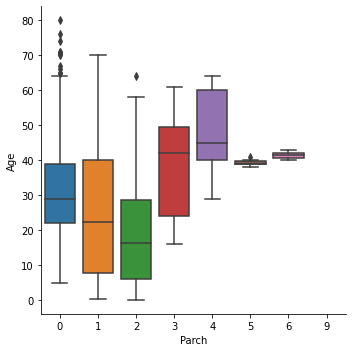

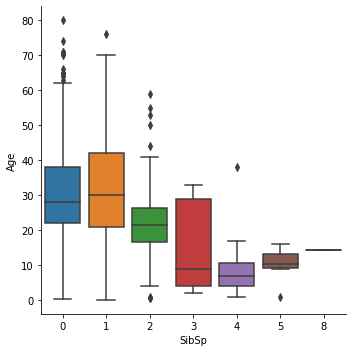

In [50]:
sns.catplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'SibSp',kind = 'box', data = combine)

<AxesSubplot:>

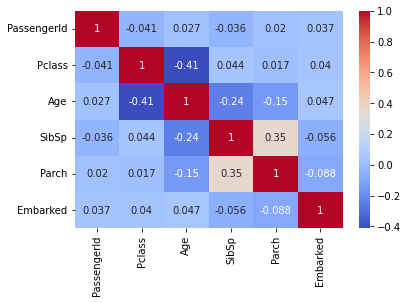

In [51]:
sns.heatmap(combine.drop(['Survived', 'Fare', 'Sex'], axis = 1).corr(), annot=True, cmap = 'coolwarm')

In [52]:
age_nan_indices = list(combine[combine['Age'].isnull()].index)
print(age_nan_indices)
print("No of nan values in 'Age' : " , len(age_nan_indices))

[5, 17, 19, 26, 27, 28, 30, 31, 35, 41, 44, 45, 46, 47, 54, 63, 64, 75, 76, 81, 86, 93, 99, 105, 107, 119, 124, 126, 138, 152, 156, 163, 165, 173, 177, 181, 182, 192, 194, 209, 218, 224, 230, 235, 236, 245, 251, 255, 259, 265, 269, 272, 279, 290, 293, 295, 296, 298, 299, 301, 324, 328, 329, 340, 344, 347, 351, 352, 357, 360, 361, 368, 377, 381, 402, 403, 404, 406, 408, 413, 418, 421, 424, 437, 444, 447, 450, 452, 457, 459, 461, 463, 468, 474, 478, 483, 488, 490, 495, 500, 504, 510, 515, 517, 520, 524, 526, 531, 540, 545, 550, 553, 556, 557, 561, 566, 571, 577, 582, 586, 589, 591, 594, 595, 604, 605, 606, 622, 626, 632, 636, 641, 643, 646, 649, 660, 662, 667, 673, 685, 690, 702, 704, 711, 720, 725, 731, 732, 733, 753, 759, 761, 766, 769, 771, 776, 783, 785, 807, 817, 818, 820, 824, 829, 831, 840, 850, 858, 868, 878, 891, 903, 910, 914, 917, 920, 922, 928, 935, 939, 946, 957, 964, 965, 966, 969, 972, 974, 983, 988, 989, 992, 997, 1002, 1005, 1008, 1013, 1014, 1027, 1029, 1032, 1041, 1044

In [53]:
# loop through list created and impute the missing values in the 'Age' feature

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                 &(combine['Parch'] == combine.iloc[index]['Parch'])
                                 &(combine['Pclass'] == combine.iloc[index]['Pclass'])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [54]:
combine['Age'].isnull().sum()

0

Text(3.674999999999997, 0.5, 'Passenger Fare Distribution')

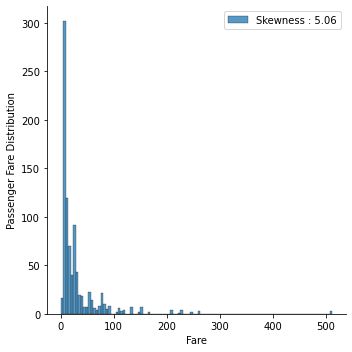

In [55]:
sns.displot(train['Fare'], label='Skewness : %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

In [56]:
#Applying log transformation

combine['Fare'] = combine['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

Text(3.674999999999997, 0.5, 'Passenger Fare Distribution')

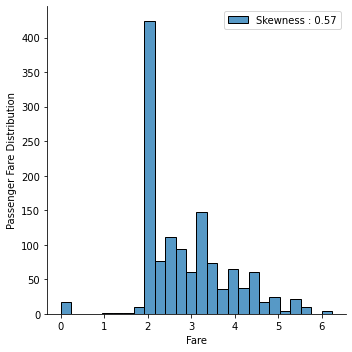

In [57]:
sns.displot(combine['Fare'], label='Skewness : %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

### Feature Engineering

In [58]:
combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [59]:
combine[['FamilySize', 'Survived']].groupby('FamilySize',as_index = False).mean().sort_values(by='Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [60]:
combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [61]:
combine[['IsAlone', 'Survived']].groupby('IsAlone',as_index = False).mean().sort_values(by='Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [62]:
combine.drop(['PassengerId', 'SibSp', 'Parch', 'FamilySize'], axis = 1, inplace = True)

In [63]:
combine.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0.0,3,0,22.0,1.981001,0,0
1,1.0,1,1,38.0,4.266662,1,0
2,1.0,3,1,26.0,2.070022,0,1
3,1.0,1,1,35.0,3.972177,0,0
4,0.0,3,0,35.0,2.085672,0,1


In [64]:
# Separating training and testing data from combine

train = combine[:len(train)]
test = combine[len(train):]

In [65]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0.0,3,0,22.0,1.981001,0,0
1,1.0,1,1,38.0,4.266662,1,0
2,1.0,3,1,26.0,2.070022,0,1
3,1.0,1,1,35.0,3.972177,0,0
4,0.0,3,0,35.0,2.085672,0,1


In [66]:
test.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
881,NaN,3,0,34.5,2.057860,2,1
882,NaN,3,1,47.0,1.945910,0,0
883,NaN,2,0,62.0,2.270836,2,1
884,NaN,3,0,27.0,2.159003,0,1
885,NaN,3,1,22.0,2.508582,0,0


In [67]:
train['Survived'] = train['Survived'].astype('int32')
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,0,22.0,1.981001,0,0
1,1,1,1,38.0,4.266662,1,0
2,1,3,1,26.0,2.070022,0,1
3,1,1,1,35.0,3.972177,0,0
4,0,3,0,35.0,2.085672,0,1


In [68]:
test.drop('Survived', axis = 1, inplace = True)

In [69]:
test.head()     # ---> X_test

,Pclass,Sex,Age,Fare,Embarked,IsAlone
881,3,0,34.5,2.057860,2,1
882,3,1,47.0,1.945910,0,0
883,2,0,62.0,2.270836,2,1
884,3,0,27.0,2.159003,0,1
885,3,1,22.0,2.508582,0,0


# 4. Modelling & Evaluation

In [70]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test.copy()

In [71]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (881, 6)
y_train shape :  (881,)
X_test shape :  (418, 6)


## 4.1. Logistic Regression

In [72]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
acc_logreg = round(logreg.score(X_train,y_train)*100,2)
acc_logreg

80.14

## 4.2. Support Vector Machines

In [73]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train,y_train)*100,2)
acc_svc

69.81

## 4.3. KNN

In [74]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train,y_train)*100,2)
acc_knn

84.9

## 4.4. Gaussian Naive Bayes

In [75]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
acc_gnb = round(gnb.score(X_train,y_train)*100,2)
acc_gnb

77.41

## 4.5. Random Forest Classifier

In [76]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
acc_rf = round(rf.score(X_train,y_train)*100,2)
acc_rf

98.07

## 4.6. Decision Tree Classifier

In [77]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
acc_dtc = round(knn.score(X_train,y_train)*100,2)
acc_dtc

84.9

# Evaluation
> K-Fold Cross Validation

In [78]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(DecisionTreeClassifier())

In [79]:
len(classifiers)

6

In [80]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = 10))

In [81]:
cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [82]:
cv_res = pd.DataFrame({'Cross Validation Mean' : cv_mean, 'Cross Validation Std' : cv_std, 'Algorithms' : ['Logistic Regression', 'Support Vector Machine', 'KNN', 'GaussianNB', 'Random Forest', 'Decision Tree']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithms
0,0.816177,0.038934,Random Forest
1,0.794548,0.028517,Logistic Regression
2,0.788904,0.034714,Decision Tree
3,0.769612,0.034235,GaussianNB
4,0.752630,0.043389,KNN
5,0.690181,0.045856,Support Vector Machine


## Hyperparameter Tuning of SVM

In [116]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000],
             'gamma':[1, 0.1, 0.01, 0.001, 0.0001],
             'kernel':['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.616 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.655 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.648 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.653 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.627 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.744 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.801 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.801 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.841 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.831 total time=   0.0s
[CV 2/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [117]:
print('Best Parameters : ', grid.best_params_)
print('Best Estimator : ', grid.best_estimator_)

Best Parameters :  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator :  SVC(C=100, gamma=0.01)


In [118]:
svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train,y_train)*100,2)
acc_svc

83.65

In [119]:
cross_val_score(svc, X_train, y_train, scoring = 'accuracy', cv = 10).mean()

0.8229315628192033

Our Cross Validation Score has improved